In [2]:
import os
import sys
import time
import yaml
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
# add parent directory to system path
sys.path.append('..\\..')
from src.utils import *

In [3]:
# show current databases in data folder
cwd = os.getcwd()
analysis_path = os.path.abspath(os.path.join(cwd, os.pardir))
parent_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
figure_path = f"{cwd}\\figures\\debt_rank"
data_path = f"{parent_path}\\data"
databases = os.listdir(data_path)
print(f"databases = {databases}")

databases = ['growth.db', 'growth2.db', 'nogrowth.db', 'nogrowth2.db']


In [4]:
# change matplotlib font to serif
plt.rcParams['font.family'] = ['serif']
# figure size
x_figsize = 10
y_figsize = x_figsize/1.7
# large fontsize
large = 18
# small fontsize
small = 14
# load model parameters
params = load_parameters(f'{parent_path}\\src\\parameters.yml')
# analysis parameters
simulations = params['simulation']['num_sims']
steps = params['simulation']['steps']
start = params['simulation']['start']*steps
end = (params['simulation']['start'] + params['simulation']['years'])*steps
middle = int(end/2)
years = np.linspace(0, params['simulation']['years'], params['simulation']['years']*steps)

In [5]:
# connect to sql database
# database index
index = 0
# get database name
database_name = databases[index]
# suffix for saved file
suffix = database_name[:-3]
# create connection to database
con = sqlite3.connect(f"{data_path}\\{database_name}")
# create database cursor
cur = con.cursor()

In [6]:
def update_in_distress(state: pd.Series):
    return np.where(state == 'D', 1, 0)

def update_distress(distress: pd.Series, W: pd.DataFrame, other_distress: pd.Series, other_in_distress: pd.Series):
    return np.minimum(1, distress + (W@(other_distress*other_in_distress)))

def update_state(distress: pd.Series, state: pd.Series):
    new_state = np.where((distress > 0) & (state != 'I'), 'D', state)
    new_state = np.where(state == 'D', 'I', new_state)
    return new_state

def bank_debt_rank(index: int, distress: pd.Series, assets: pd.Series):
    total_assets = np.sum(assets.drop(index))
    return np.sum(distress.drop(index)*(assets.drop(index)/total_assets))

def firm_debt_rank(distress: pd.Series, assets: pd.Series):
    total_assets = np.sum(assets)
    return np.sum(distress*(assets/total_assets))

def calculate_debt_rank(C: pd.DataFrame, bank_assets: pd.DataFrame, firm_assets: pd.DataFrame):
    """
    Calculates total debt rank of bank and firm bipartite credit network.
    
    Parameter
    ---------
        C : pd.DataFrame
            credit network loan matrix
        
        bank_assets : pd.DataFrame
            bank assets  
        
        firm_assets : pd.DataFrame
            firm assets 
    
    Returns
    -------
        debt rank : float
            debt rank of credit network loan matrix C
    """
    # bank propagation matrix
    W_banks = (C.T/C.sum(axis=1))
    # firm propagation matrix
    W_firms = (C/C.T.sum(axis=1))
    # debt rank data
    num_banks = C.shape[0]
    num_firms = C.shape[1]
    debt_rank = pd.DataFrame({'banks': [0.0]*num_banks, 'firms': [0.0]*num_banks, 'total': [0.0]*num_banks})
    debt_rank.index = C.index
    # bank data used in DebtRank algorith
    banks = pd.DataFrame({'id': C.index, 'distress': [0.0]*num_banks, 'state': ['U']*num_banks, 'in_distress': [0.0]*num_banks})
    # add bank assets to data 
    banks = banks.merge(bank_assets, on='id')
    # redefine index values 
    banks.index = C.index
    # firm data used in DebtRank algorith
    firms = pd.DataFrame({'id': C.columns, 'distress': [0.0]*num_firms, 'state': ['U']*num_firms, 'in_distress': [0.0]*num_firms})
    # add firm assets to data 
    firms = firms.merge(firm_assets, on='id')
    # redefine index values
    firms.index = pd.Index(C.columns)
    for i in range(num_banks):
        # reset bank data 
        banks['distress'] = 0
        banks['state'] = 'U'
        banks['in_distress'] = 0
        # reset firm data 
        firms['distress'] = 0
        firms['state'] = 'U'
        firms['in_distress'] = 0
        # node i becomes distressed
        index = banks.index[i]
        banks.loc[index,'distress'] = 1
        banks.loc[index,'state'] = 'D'
        # convergence accuracy 
        epsilon = 0.001
        # convergence difference
        delta = 100
        while delta > epsilon:
            # starting distress
            start_distress = firms['distress'].sum() + banks['distress'].sum()
            # check if banks are in distress
            banks['in_distress'] = update_in_distress(banks['state'])
            # update firms distress h
            firms['distress'] = update_distress(firms['distress'], W_banks, banks['distress'], banks['in_distress'])
            # update firms state s
            firms['state'] = update_state(firms['distress'], firms['state'])
            # check if firms are in distress
            firms['in_distress'] = update_in_distress(firms['state'])
            # update banks distress h
            banks['distress'] = update_distress(banks['distress'], W_firms, firms['distress'], firms['in_distress'])
            # update banks state s
            banks['state'] = update_state(banks['distress'], banks['state'])
            # ending distress 
            end_distress = firms['distress'].sum() + banks['distress'].sum()
            # distress difference 
            delta = end_distress - start_distress
        # bank debt rank of bank node i 
        debt_rank.loc[index, 'banks'] = bank_debt_rank(index, banks['distress'], banks['bank_assets'])
        debt_rank.loc[index, 'firms'] = firm_debt_rank(firms['distress'], firms['firm_assets'])
    # total debt rank
    debt_rank['total'] = debt_rank['banks'] + debt_rank['firms']
    # return sum of total debt rank 
    return debt_rank['total'].sum()


In [7]:
# get edges data
edges = pd.read_sql_query(
    f"""
        SELECT *
        FROM 
            edge_data
        WHERE 
            time > {start}
    ;
    """,
    con
)
edges

In [ ]:
# create dataframe to store debt rank data
data = edges.drop_duplicates(subset=['simulation', 'time'])[['simulation', 'time']]
# initialise debt rank to 0 for all simulations and periods
data['debt_rank'] = 0.0
# reset dataframe index
data.reset_index(inplace=True, drop=True)
data

,simulation,time,debt_rank
0,0,201,0.0
1,0,202,0.0
2,0,203,0.0
3,0,204,0.0
4,0,205,0.0
...,...,...,...
19995,49,596,0.0
19996,49,597,0.0
19997,49,598,0.0
19998,49,599,0.0


In [ ]:
# loop over number of simulations
for s in range(simulations):
    # calculate debt rank for each period
    for t in range(start+1, end+1):
        # edges for current time period t
        current_edges = edges.loc[(edges['simulation'] == s) & (edges['time'] == t)]
        # bank assets in period t
        bank_assets = current_edges.drop_duplicates(subset=['source']).loc[:,['source', 'bank_assets']]
        # rename column
        bank_assets = bank_assets.rename(columns={'source': 'id'})
        # firm assets in period t
        firm_assets = current_edges.drop_duplicates(subset=['target']).loc[:,['target', 'firm_assets']]
        # rename column
        firm_assets = firm_assets.rename(columns={'target': 'id'})
        # credit network loan matrix
        C = pd.pivot_table(current_edges, values=['loan'], index=['source'], columns=['target']).fillna(0)
        C.columns = [col[1] for col in C.columns]
        C.index = pd.Index([i for i in C.index])
        # calculate total bank and firm debt rank in period t
        data.loc[(data['simulation'] == s) & (data['time'] == t), 'debt_rank'] = calculate_debt_rank(C, bank_assets, firm_assets)

In [ ]:
group = data.groupby(by=['time'])
median = group.quantile(0.5)
upper = group.quantile(0.95)
lower = group.quantile(0.05)

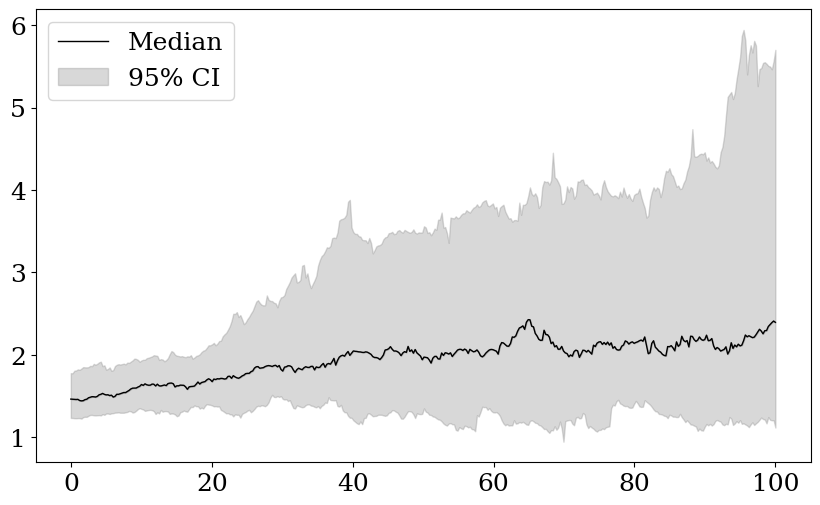

In [ ]:
# group simulation data
group = data.groupby(by=['time'])
# median debt rank over simulations
median = group.quantile(0.5)
# 95% confidence interval
upper = group.quantile(0.95)
# 5% confidence interval
lower = group.quantile(0.05)

plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, median['debt_rank'], color='k', linewidth=1, label='Median')
plt.fill_between(years, median['debt_rank'], upper['debt_rank'], color='grey', alpha=0.3, label='95% CI')
plt.fill_between(years, median['debt_rank'], lower['debt_rank'], color='grey', alpha=0.3)
# legend
plt.legend(loc='upper left', fontsize=large)
# ticks 
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\debt_rank_{suffix}.png', bbox_inches='tight')
plt.show()